# Beginning Machine Learning with scikit-learn

## Continuous Target Values

For a regression, we want a range of target values, not a binary category. Having one-hot encoded binary features with a target that is more ordinal than continuous is close to the worst case for using a regression. It's time to move away from the "Learning about Humans learning ML" dataset. We will use a well-known example dataset that is included with scikit-learn for this next section.

In [1]:
from src.setup import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Sample Datasets

A number of sample datasets are included with scikit-learn, either already bundled with a `load_*()` function for the smaller ones or with a `fetch_*()` function for the larger ones that can be obtained online. The `make_*()` functions create synthetic datasets with some randomness in their generation.

In [2]:
from sklearn import datasets
[attr for attr in dir(datasets) if not attr.startswith('_')]

['clear_data_home',
 'dump_svmlight_file',
 'fetch_20newsgroups',
 'fetch_20newsgroups_vectorized',
 'fetch_california_housing',
 'fetch_covtype',
 'fetch_kddcup99',
 'fetch_lfw_pairs',
 'fetch_lfw_people',
 'fetch_olivetti_faces',
 'fetch_openml',
 'fetch_rcv1',
 'fetch_species_distributions',
 'get_data_home',
 'load_boston',
 'load_breast_cancer',
 'load_diabetes',
 'load_digits',
 'load_files',
 'load_iris',
 'load_linnerud',
 'load_sample_image',
 'load_sample_images',
 'load_svmlight_file',
 'load_svmlight_files',
 'load_wine',
 'make_biclusters',
 'make_blobs',
 'make_checkerboard',
 'make_circles',
 'make_classification',
 'make_friedman1',
 'make_friedman2',
 'make_friedman3',
 'make_gaussian_quantiles',
 'make_hastie_10_2',
 'make_low_rank_matrix',
 'make_moons',
 'make_multilabel_classification',
 'make_regression',
 'make_s_curve',
 'make_sparse_coded_signal',
 'make_sparse_spd_matrix',
 'make_sparse_uncorrelated',
 'make_spd_matrix',
 'make_swiss_roll']

## California Housing Data

One downloadable dataset is the California housing data.  It has a target of house price, and 8 features.  There are 20 thousands samples in it, so it is reasonably large sized.  That is, it is nowhere close to the modern datasets of millions or billions of observations we sometimes work with; but it is also not a toy dataset of dozens or hundreds of observations that are often shown for demonstration purposes (including in prior lessons of this course).

In [3]:
# To demonstrate downloading, remove cached version of dataset
!ls ~/scikit_learn_data
!rm ~/scikit_learn_data/*

cal_housing_py3.pkz


In [4]:
california = datasets.fetch_california_housing()

In [5]:
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

For convenience, it is often useful to massage the standard format of scikit-learn dataset objects.  These objects all have a attributes `.DESCR`, `.feature_names`, `.data`, `.target`.  The latter two are NumPy arrays.  The feature names are simply a Python list of strings.  The description is a single string that has newlines and simple formatting with citations and links inside it.

The California housing dataset has a fairly brief description.  For comparison, the Boston housing dataset has fewer observations but more citational detail.

In [6]:
print(datasets.load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [7]:
california.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [8]:
print("Features:", california.data.shape, california.data.dtype)
print("Target:", california.target.shape, california.target.dtype)

Features: (20640, 8) float64
Target: (20640,) float64


In [9]:
# One DataFrame for everything
df_ca = pd.DataFrame(california.data, columns=california.feature_names)
df_ca['TARGET'] = california.target
df_ca.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We might wonder what the units are for the target variable of house price.  Consulting the [function documentation](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) we can determine that is multiples of $100,000 (presumably 1997 dollars and prices, given citation).

Looking at some summary statistics is always worthwhile before we jump into our actual model.

In [10]:
df_ca.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
TARGET,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


## Comparing a Gaggle of Regressors

The DataFrame is useful for getting sense of the data, but for scikit-learn itself, we simply want to work with the `.data` and `.target` arrays.

In [11]:
X = california.data
y = california.target

For validation—as usual—we want a train/test split.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

The metrics we use in the below code are `explained_variance_score`, `mean_absolute_error`, and `r2_score`. Many other metrics are are available, mostly within the `sklearn.metrics` submodule.

In [13]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

The particular regressors we choose does not reflect any deep decision. Most are somewhat in the family of linear regression. RANSAC is tried because it is meant to be more resilient against outliers in data. This is sometimes more strongly predictive than generic linear regression. One of several Gaussian techniques is shown as an example—it behaves worthlessly for this example, at least without hyperparameter tuning.

In [14]:
from time import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

regressors = [
    LinearRegression(), 
    RANSACRegressor(), 
    KNeighborsRegressor(),
    KNeighborsRegressor(n_neighbors=9, metric='manhattan'),
    SVR(),
    LinearSVR(),
    GaussianProcessRegressor(),
    SVR(kernel='linear'), # Cf. LinearSVR: much slower, might be better or worse: 
]

In [15]:
head = 6
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    predictions = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, predictions))
    print("\tMean absolute error:", mean_absolute_error(y_test, predictions))
    print("\tR2 score:", r2_score(y_test, predictions))
    print()

LinearRegression()
	Training time: 0.035s
	Prediction time: 0.001s
	Explained variance: 0.5932507305237988
	Mean absolute error: 0.5351008445282192
	R2 score: 0.592986928576023

RANSACRegressor()
	Training time: 0.692s
	Prediction time: 0.001s
	Explained variance: -0.012622018044454286
	Mean absolute error: 0.673161323553014
	R2 score: -0.13461730449931375

KNeighborsRegressor()
	Training time: 0.058s
	Prediction time: 0.101s
	Explained variance: 0.1333754653693935
	Mean absolute error: 0.8239869414728682
	R2 score: 0.1327382432277131

KNeighborsRegressor(metric='manhattan', n_neighbors=9)
	Training time: 0.024s
	Prediction time: 0.071s
	Explained variance: 0.23490556490024728
	Mean absolute error: 0.7712127140396211
	R2 score: 0.23462636655199864

SVR()
	Training time: 3.887s
	Prediction time: 0.213s
	Explained variance: 0.030135238640570994
	Mean absolute error: 0.861319578677006
	R2 score: -0.01098545930636674

LinearSVR()
	Training time: 1.318s
	Prediction time: 0.056s
	Explained v

Two models that are very slow to train are omitted in the "live" output in this course.  Those outputs would be the following:

```
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
    Training time: 161.517s
    Prediction time: 4.571s
    Explained variance: -0.0199393545636
    Mean absolute error: 1.91320341763
    R2 score: -2.79445305731
    
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
    Training time: 4458.012s
    Prediction time: 0.843s
    Explained variance: 0.527882057056
    Mean absolute error: 0.601893862699
    R2 score: 0.517431654021
```

Neither of these has an especially good R2 score for this particular data.  `GaussianProcessRegressor` is negative, in fact (which is very bad).  `SVR` with a linear kernel is moderately good, but not better than simple `LinearRegression`.  However, notice that even though training took well over an hour, prediction takes less than a second.  That is not the fasted predictor, but it is also not the slowest among those that train orders of magnitude faster.  If this model performed the best, it might be worth spending the one-time training cost, and then be able to regress sufficiently quickly.

## Linear Models

With high dimensionality, plain linear regression tends to perform surprisingly well.  Variants may add improvements, but this technique from general statistics, or analytic math, is quite good—notwithstanding that it basically pre-dates machine learning per se.  A simple linear regression basically assumes the following:

* as a feature value varies, the target value varies proportionally
  * responses to features are global
  * responses are strictly linear
* features are not co-linear

Even if these assumptions are not stricly true, the model may perform well.  One common strategy to mitigate variance from these assumptions is to *penalize* the weights (coefficients) assigned to each feature.  An "$l1$ penalty" is known as Lasso regression and will force some coefficients to zero.  An $l2$ penalty is known as Ridge regression and damps coefficients.

### Equations and Visualizations for Penalties

In more detail, I plain linear regression is this calculation:

$$ \text{min}_{w, b} \sum_i || w^\mathsf{T}x_i + b  - y_i||^2 $$

For Lasso regression (**L**east **a**bsolute **s**hrinkage **s**election **o**perator), the equation is:

$$ \text{min}_{w, b} \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_1$$

For Ridge regression, the equation is:

$$ \text{min}_{w,b}  \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_2^2$$ 

The second term in the right hand side of the equation below is the L2 regularization that is part of ridge regression ($\alpha$ is usually chosen between 0.01 and 100).  The idea in Ridge regression is to mutually minimize the error terms and the penalty constant.

It is probably easier to visualize these than look at the equations.  Ridge regression may be a good choice when there are colinear predictors in the `X` matrix.  In the simplest characterization, Ridge pulls the OLS (ordinary least square) estimators closer to zero (but not actually set them to exactly zero).

![Geometric Interpretation of Ridge Regression](img/ridge_regression_geomteric.png)

Contrasting Lasso and Ridge (or $l1$ versus $l2$) we can visualize the difference as below.  Notice that some coefficients are actually zeroes in the Lasso model.

![L1 versus L2 regions](img/L1_and_L2_balls.png)

Let's try this all out.

In [16]:
from sklearn.linear_model import Lasso, Ridge

lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()

for model in [lr, lasso, ridge]:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_test, predictions))
    print("\tMean absolute error:", mean_absolute_error(y_test, predictions))
    print("\tR2 score:", r2_score(y_test, predictions))
    print()

LinearRegression()
	Explained variance: 0.5932507305237988
	Mean absolute error: 0.5351008445282192
	R2 score: 0.592986928576023

Lasso()
	Explained variance: 0.28970690474140004
	Mean absolute error: 0.7658634070433801
	R2 score: 0.288879512535411

Ridge()
	Explained variance: 0.5932485147045006
	Mean absolute error: 0.5351099629542129
	R2 score: 0.5929846671576726



## Pitfalls of Linear Models

Famously, there can be many features of data that are not well captured in any (naïve) linear model. [Francis Anscombe](https://en.wikipedia.org/wiki/Frank_Anscombe) created his [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) as an illustration of this. The several distributions in it have nearly the same or identical means and variances along X and Y axes, have almost the same correlations of X and Y, have the same linear regression lines and coefficient of determination. 

Let us look at some basic statistics and regressions on this data. Let us also look at the statistical properties of the elements of the quartet. In particular, notice the means and standard deviations (of both the x and y features), and the min/max and quartiles of the first three x feature collections.

This sample dataset is included in the Seaborn visualization library:

In [17]:
import seaborn as sns
df = sns.load_dataset("anscombe")
df.pivot(columns='dataset').describe()

x                                           y             \
dataset          I         II        III         IV          I         II   
count    11.000000  11.000000  11.000000  11.000000  11.000000  11.000000   
mean      9.000000   9.000000   9.000000   9.000000   7.500909   7.500909   
std       3.316625   3.316625   3.316625   3.316625   2.031568   2.031657   
min       4.000000   4.000000   4.000000   8.000000   4.260000   3.100000   
25%       6.500000   6.500000   6.500000   8.000000   6.315000   6.695000   
50%       9.000000   9.000000   9.000000   8.000000   7.580000   8.140000   
75%      11.500000  11.500000  11.500000   8.000000   8.570000   8.950000   
max      14.000000  14.000000  14.000000  19.000000  10.840000   9.260000   

                               
dataset        III         IV  
count    11.000000  11.000000  
mean      7.500000   7.500909  
std       2.030424   2.030579  
min       5.390000   5.250000  
25%       6.250000   6.170000  
50%       7.110000   7.040000  
75%       7.980000   8.190000  
max      12.740000  12.500000

The overall data collection has similar (but not quite identical) properties to its subsects.

We might hope to tease apart what is going on with the several subsets by looking at the correlation of the features. Other than some floating point approximations, these are also identical.

In [18]:
import numpy as np
df_1 = df[df.dataset=='I']
df_2 = df[df.dataset=='II']
df_3 = df[df.dataset=='III']
df_4 = df[df.dataset=='IV']

(np.corrcoef(df_1.x, df_1.y)[1,0],
 np.corrcoef(df_2.x, df_2.y)[1,0],
 np.corrcoef(df_3.x, df_3.y)[1,0],
 np.corrcoef(df_4.x, df_4.y)[1,0])

(0.8164205163448399,
 0.8162365060002428,
 0.8162867394895984,
 0.8165214368885029)

Actually visualizing the data gives us a very distinctly different impression of the data subsets.  The linear regressions are identical (under an [ordinary least squares fit](https://en.wikipedia.org/wiki/Ordinary_least_squares) here, but the point would be the same with a different fitting regime).

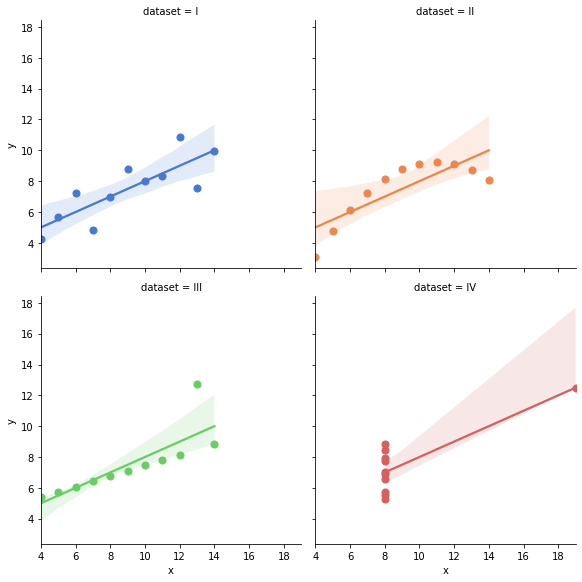

In [19]:
%matplotlib inline
# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1});


### The Datasaurus

Humorously, Justin Matejka and George Fitzmaurice give a similar example with the [Datasaurus](https://www.autodeskresearch.com/publications/samestats) in _Same Stats, Different Graphs: Generating Datasets with Varied Appearance and Identical Statistics through Simulated Annealing_:

<img src="img/DataDino-600x455.gif" width="50%"/>

### The Moral of the Pitfalls

Obviously, the concerns raised by Anscombe hardly mean we should not use linear models.  In the examples we have looked at, basic OLS linear regression performed as well or better than all the other models we tried.  But there are certainly special cases where linear regression will be unable to distingish distributions whereas other techniques might be able to.

There is a tradeoff in these kinds of situations between two approaches.  One approach would be to use more feature engineering and general data cleanup before we get to our linear regression step.  We will think about those possibilities in later chapters.  Another approach is to choose a different family of model from the start, and avoid the particular pitfalls the linear models have (but encounter other pitfalls in their place).

## Non-linear Regressors

Scikit-learn has a large number of additional regression models that are not based on linear models.  One relatively easy one to understand is `DecisionTreeRegressor`.  

The code below is adapted slightly from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py). Here we add an Epsilon-Support Vector Regression (`SVR`) regressor as well as a decision tree to show the contrast.

In the below one dimensional dataset, SVR produced a smoothed result that is much closer to the jittered sine curve that was used generate the points.  That is not really the point to the example though.  We want to get a visual sense of the kind of thing a decision tree is doing as a regressor rather than a classifier.  In higher dimensional cases, deciding continuous cut-points is often more effective than a smoothed kernel (and non-synthetic data isn't necessarily so smooth to start with). 

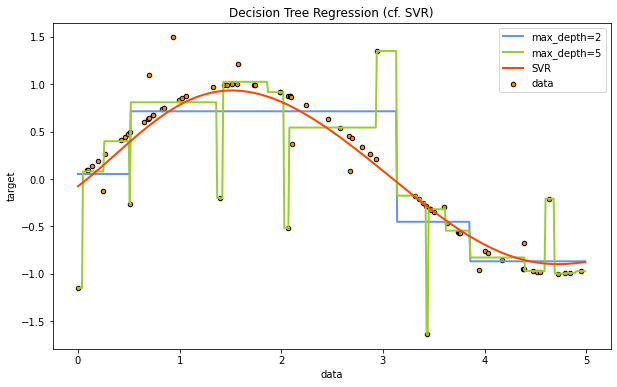

<Figure size 432x288 with 0 Axes>

In [20]:
%run src/decisiontree_regressor.py

We can see that `DecisionTreeRegressor` is conceptually similar to `DecisionTreeClassifier`.  At certain cut-points in the data (here just one dimension) a switch is made to a different target value.  However, rather than simply predict a flipped boolean value as in the prior lesson, we predict a new quantitative level for the target around cut points.

### Non-linearity in California Housing

Let us try a decision tree style against the multi-dimensional California housing data.  So far, a simple `LinearRegression` was the best we had done against this dataset.  As well as `DecisionTreeRegressor` of several different depths, we will add in `RandomForestRegressor`.  From [the documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html):

> A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(
        california.data, california.target, random_state=1)

regressors = [LinearRegression(),
              DecisionTreeRegressor(max_depth=5),
              DecisionTreeRegressor(max_depth=10),
              DecisionTreeRegressor(max_depth=20),
              RandomForestRegressor(max_depth=10),
              GradientBoostingRegressor(n_estimators=200),
              SVR(),]

for model in regressors:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_test, predictions))
    print("\tMean absolute error:", mean_absolute_error(y_test, predictions))
    print("\tR2 score:", r2_score(y_test, predictions))
    print()

LinearRegression()
	Explained variance: 0.5932507305237988
	Mean absolute error: 0.5351008445282192
	R2 score: 0.592986928576023

DecisionTreeRegressor(max_depth=5)
	Explained variance: 0.6141535088942047
	Mean absolute error: 0.5179253361670072
	R2 score: 0.6140595840918429

DecisionTreeRegressor(max_depth=10)
	Explained variance: 0.6821334621615892
	Mean absolute error: 0.42091408442434036
	R2 score: 0.6821063813946118

DecisionTreeRegressor(max_depth=20)
	Explained variance: 0.6008598188814946
	Mean absolute error: 0.4590843617925426
	R2 score: 0.6006906405683217

RandomForestRegressor(max_depth=10)
	Explained variance: 0.7767981649892417
	Mean absolute error: 0.36410414080409353
	R2 score: 0.7767860000231357

GradientBoostingRegressor(n_estimators=200)
	Explained variance: 0.7988168460661118
	Mean absolute error: 0.34963288211412713
	R2 score: 0.7988015144754126

SVR()
	Explained variance: 0.030135238640570994
	Mean absolute error: 0.861319578677006
	R2 score: -0.01098545930636674


At least three things to notice about this latest batch of comparisons:

* SVR (with an RBF kernel) does very poorly.  Smoothing around a kernel does not necessarily product best results.  Intuitively to me, I would expect this because housing prices tend to fall into plateaus around certain features (for example, houses in cities at particular latitude/longitude locations are characteristically spendy or cheap, depending on the city).
* The quality of a decision tree is sensitive to its depth.  The `max_depth` of 10 may or may not be optimal, but some higher and lower values are worse.
* As largely expected, a random forest improves on a decision tree.  Because cut points and their order are decided partially randomly, averaging a collection (10 by default) of these tends to produce a better result.  These algorithms are no among the expensive ones, but averaging ten decision trees will straightforwardly take 10x the time or cores as will just one tree.
* A `GradientBoostingRegressor` does best here, by a slight margin.  This is an ensemble like `RandomForestRegressor`, but it works slightly differently.  Rather than simply train many relatively deep trees, a gradient boosting approach fits very shallow trees in sequence.  Each new weak predictor does not try to predict from the initial features to the target, but rather is a prediction from the residuals (the errors) of the last predictor.

## Next Lesson

**Hyperparameters**: In the current lessson we looked at several regression models, with a particular focus on both the strength and the limits of linear models.

To some extent, we have utilized hyperparameters in passing at many places in these lessons.  The next lesson will focus on working with hyperparameters more systematically.

<a href="Hyperparameters.ipynb"><img src="img/open-notebook.png" align="left"/></a>